In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from surprise import accuracy

%run 05_hybrid_model.ipynb


Train size: (80668, 3) Test size: (20168, 3)


# 1. RMSE i MAE funkcije

In [2]:
def rmse_from_preds(preds):
    """
    preds: lista tuple-ova (uid, iid, true_r, est, _)
    """
    y_true = np.array([p[2] for p in preds], dtype=float)
    y_pred = np.array([p[3] for p in preds], dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))


def mae_from_preds(preds):
    y_true = np.array([p[2] for p in preds], dtype=float)
    y_pred = np.array([p[3] for p in preds], dtype=float)
    return float(np.mean(np.abs(y_true - y_pred)))


# 2. Precission i Recall

In [3]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """
    predictions: lista tuple-ova (uid, iid, true_r, est, _)
    k: koliko preporuka po korisniku posmatramo
    threshold: minimalna ocena da bi se item smatrao "relevantnim"
    """

    # mapiranje korisnik -> lista (iid, true_r, est)
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((iid, true_r, est))

    precisions = {}
    recalls = {}

    for uid, user_ratings in user_est_true.items():
        # sortiraj po predikciji (est) opadajuće
        user_ratings.sort(key=lambda x: x[2], reverse=True)

        # top-k
        top_k = user_ratings[:k]

        # broj relevantnih itema u top-k (true_r >= threshold)
        n_rel_and_rec_k = sum((true_r >= threshold) for (_, true_r, _) in top_k)

        # ukupan broj relevantnih itema kod korisnika (uopšte)
        n_rel = sum((true_r >= threshold) for (_, true_r, _) in user_ratings)

        # broj preporučenih itema u top-k
        n_rec_k = len(top_k)

        # izbegni deljenje 0
        if n_rec_k != 0:
            precisions[uid] = n_rel_and_rec_k / n_rec_k
        else:
            precisions[uid] = 0.0

        if n_rel != 0:
            recalls[uid] = n_rel_and_rec_k / n_rel
        else:
            recalls[uid] = 0.0

    # prosečan precision i recall preko korisnika
    mean_precision = sum(precisions.values()) / len(precisions) if precisions else 0.0
    mean_recall = sum(recalls.values()) / len(recalls) if recalls else 0.0

    return mean_precision, mean_recall


# 3. Testiranje

In [13]:
# 1) SVD / CF
pred_svd = make_predictions_svd(test_df, svd_model)

# 2) CBF i Hybrid
pred_cbf, pred_hyb = make_predictions_cbf_hybrid(
    test_df=test_df,
    train_df=train_df,
    df_movies=df_movies,
    X=X_cbf,
    svd_model=svd_model,
    alpha_cf=0.8
)

len(pred_svd), len(pred_cbf), len(pred_hyb)


(20168, 20168, 20168)

In [14]:
metrics = []

for name, preds in [
    ("CF_SVD", pred_svd),
    ("CBF_only", pred_cbf),
    ("Hybrid", pred_hyb),
]:
    rmse = rmse_from_preds(preds)
    mae = mae_from_preds(preds)
    metrics.append({"model": name, "RMSE": rmse, "MAE": mae})

df_metrics_rmse_mae = pd.DataFrame(metrics)
df_metrics_rmse_mae


,model,RMSE,MAE
0,CF_SVD,0.873260,0.668072
1,CBF_only,1.474002,1.207091
2,Hybrid,0.891066,0.703679


In [15]:
K = 10
THRESH = 3.5

results_pr = []

for name, preds in [
    ("CF_SVD", pred_svd),
    ("CBF_only", pred_cbf),
    ("Hybrid", pred_hyb),
]:
    prec, rec = precision_recall_at_k(preds, k=K, threshold=THRESH)
    results_pr.append({
        "model": name,
        f"Precision@{K}": prec,
        f"Recall@{K}": rec
    })

df_metrics_pr = pd.DataFrame(results_pr)
df_metrics_pr


,model,Precision@10,Recall@10
0,CF_SVD,0.728828,0.658954
1,CBF_only,0.674566,0.635296
2,Hybrid,0.730796,0.660205


In [16]:
df_all = df_metrics_rmse_mae.merge(df_metrics_pr, on="model")
df_all


,model,RMSE,MAE,Precision@10,Recall@10
0,CF_SVD,0.873260,0.668072,0.728828,0.658954
1,CBF_only,1.474002,1.207091,0.674566,0.635296
2,Hybrid,0.891066,0.703679,0.730796,0.660205


In [17]:
rmse_cf = rmse_from_preds(pred_svd)
mae_cf = mae_from_preds(pred_svd)
prec_cf, rec_cf = precision_recall_at_k(pred_svd, k=10, threshold=3.5)

print("CF_SVD -> RMSE:", rmse_cf, "MAE:", mae_cf, "P@10:", prec_cf, "R@10:", rec_cf)


CF_SVD -> RMSE: 0.8732595395633489 MAE: 0.6680720298238061 P@10: 0.7288283892792088 R@10: 0.6589539889440293


In [9]:
# alphas = [a / 10 for a in range(1, 10)]  # 0.1, 0.2, ..., 0.9

# results_alpha = []

# for a in alphas:
#     print(f"Računam hybrid za alpha={a}...")
#     _, pred_hyb_a = make_predictions_cbf_hybrid(
#         test_df=test_df,
#         train_df=train_df,
#         df_movies=df_movies,
#         X=X_cbf,
#         svd_model=svd_model,
#         alpha_cf=a
#     )

#     rmse_h = rmse_from_preds(pred_hyb_a)
#     mae_h = mae_from_preds(pred_hyb_a)
#     prec_h, rec_h = precision_recall_at_k(pred_hyb_a, k=10, threshold=3.5)

#     results_alpha.append({
#         "alpha_cf": a,
#         "RMSE_hybrid": rmse_h,
#         "MAE_hybrid": mae_h,
#         "Precision@10_hybrid": prec_h,
#         "Recall@10_hybrid": rec_h
#     })

# df_alpha = pd.DataFrame(results_alpha)
# df_alpha


Računam hybrid za alpha=0.1...
Računam hybrid za alpha=0.2...
Računam hybrid za alpha=0.3...
Računam hybrid za alpha=0.4...
Računam hybrid za alpha=0.5...
Računam hybrid za alpha=0.6...
Računam hybrid za alpha=0.7...
Računam hybrid za alpha=0.8...
Računam hybrid za alpha=0.9...


,alpha_cf,RMSE_hybrid,MAE_hybrid,Precision@10_hybrid,Recall@10_hybrid
0,0.1,1.375030,1.128074,0.680960,0.639620
1,0.2,1.280648,1.052010,0.687845,0.642617
2,0.3,1.191946,0.979167,0.694894,0.645227
3,0.4,1.110287,0.910420,0.701123,0.647656
4,0.5,1.037335,0.846872,0.713091,0.652621
5,0.6,0.975047,0.790292,0.720304,0.657400
6,0.7,0.925578,0.741769,0.726042,0.659676
7,0.8,0.891066,0.703679,0.730796,0.660205
8,0.9,0.873285,0.678434,0.728337,0.658651


In [10]:
# df_cf_row = pd.DataFrame([{
#     "alpha_cf": "CF_only",
#     "RMSE_hybrid": rmse_cf,
#     "MAE_hybrid": mae_cf,
#     "Precision@10_hybrid": prec_cf,
#     "Recall@10_hybrid": rec_cf
# }])

# df_alpha_with_cf = pd.concat([df_cf_row, df_alpha], ignore_index=True)
# df_alpha_with_cf


,alpha_cf,RMSE_hybrid,MAE_hybrid,Precision@10_hybrid,Recall@10_hybrid
0,CF_only,0.873260,0.668072,0.728828,0.658954
1,0.1,1.375030,1.128074,0.680960,0.639620
2,0.2,1.280648,1.052010,0.687845,0.642617
3,0.3,1.191946,0.979167,0.694894,0.645227
4,0.4,1.110287,0.910420,0.701123,0.647656
5,0.5,1.037335,0.846872,0.713091,0.652621
6,0.6,0.975047,0.790292,0.720304,0.657400
7,0.7,0.925578,0.741769,0.726042,0.659676
8,0.8,0.891066,0.703679,0.730796,0.660205
9,0.9,0.873285,0.678434,0.728337,0.658651


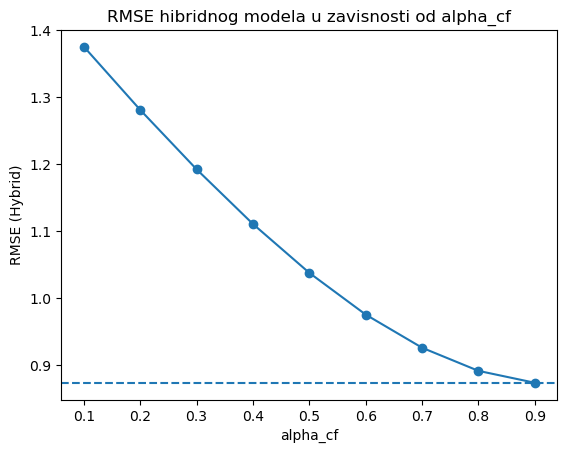

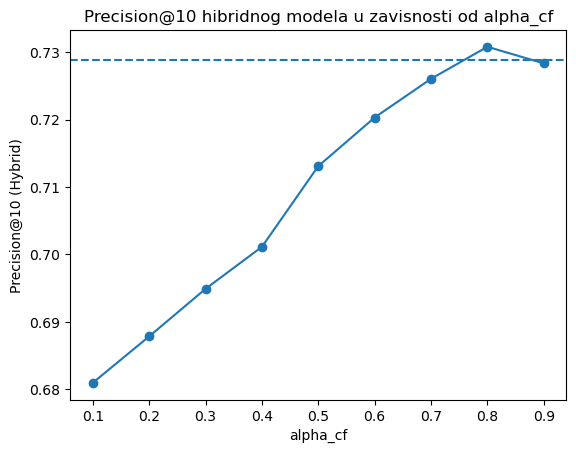

In [11]:
# import matplotlib.pyplot as plt

# plt.figure()
# plt.plot(df_alpha["alpha_cf"], df_alpha["RMSE_hybrid"], marker="o")
# plt.axhline(rmse_cf, linestyle="--")  # CF linija
# plt.xlabel("alpha_cf")
# plt.ylabel("RMSE (Hybrid)")
# plt.title("RMSE hibridnog modela u zavisnosti od alpha_cf")
# plt.show()

# plt.figure()
# plt.plot(df_alpha["alpha_cf"], df_alpha["Precision@10_hybrid"], marker="o")
# plt.axhline(prec_cf, linestyle="--")  # CF linija
# plt.xlabel("alpha_cf")
# plt.ylabel("Precision@10 (Hybrid)")
# plt.title("Precision@10 hibridnog modela u zavisnosti od alpha_cf")
# plt.show()


# 4. Čuvanje rezultata 

In [18]:
df_all.to_csv("../reports/metrics_cf_cbf_hybrid.csv", index=False)